In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import models
from keras import layers
from keras import metrics
from keras.callbacks import EarlyStopping, ModelCheckpoint

import pathlib
import cv2
import pandas


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
!unzip -n './earth_mask.zip'

Archive:  ./earth_mask.zip
  inflating: airquality.csv          
  inflating: earth_mask/baria.jpg    
  inflating: earth_mask/danang.jpg   
  inflating: earth_mask/daocathai.jpg  
  inflating: earth_mask/haiphong.jpg  
  inflating: earth_mask/halong.jpg   
  inflating: earth_mask/hanoi_caugiay.jpg  
  inflating: earth_mask/hanoi_conhue.jpg  
  inflating: earth_mask/hanoi_cuanam.jpg  
  inflating: earth_mask/hanoi_daidong.jpg  
  inflating: earth_mask/hanoi_hangbai.jpg  
  inflating: earth_mask/hanoi_minhkhai.jpg  
  inflating: earth_mask/hanoi_ngoclam.jpg  
  inflating: earth_mask/hanoi_ngocthuy.jpg  
  inflating: earth_mask/hanoi_ochodua.jpg  
  inflating: earth_mask/hanoi_quangan.jpg  
  inflating: earth_mask/hanoi_quocoai.jpg  
  inflating: earth_mask/hanoi_socson.jpg  
  inflating: earth_mask/hanoi_tayho.jpg  
  inflating: earth_mask/hanoi_tulien.jpg  
  inflating: earth_mask/hanoi_vandien.jpg  
  inflating: earth_mask/hanoi_xuandinh.jpg  
  inflating: earth_mask/hanoi_xuantao.jpg

In [3]:
# Parametres
path_csv = pathlib.Path(r'./airquality.csv')
altitude = 2.4

In [4]:
def get_data():
    print('date?')
    dataframe = pandas.read_csv(path_csv, delimiter=',', names=["ct", "airq"])
    #print(dataframe)
    npdf = np.asarray(dataframe)
    print(npdf.shape)
    l = len(npdf)
    x_list, y_list = npdf[:, 0], npdf[:, 1]
    y_list = y_list.astype('float32')
    images = np.zeros(shape=(l, 1024, 1024))
    for i in range(l):
        #im = Image.open('C:/Users/Timbo/Documents/Projet/multi/data/earth_mask/'+x_list[i]+'.jpg')
        im = cv2.imread('./earth_mask/'+x_list[i]+'.jpg')
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        images[i] = np.asarray(im).astype('float32')
        images[i] = images[i]/255
        #print(images[i])
        #im = Image.fromarray(images[i].astype('uint8'), 'L')
        #im.show()
    return x_list, y_list, images

In [5]:
def build_model(com):

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(1024, 1024, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation=None))

    if com == True:
      model.compile(
          optimizer='rmsprop',
          loss='mse',
          metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    model.summary()

    return model

In [6]:
def train_model(model):
  save_at = "macbeth.hdf5"
  save_best2 = ModelCheckpoint (save_at, monitor='val_mean_absolute_error', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

  ifn, labels, images = get_data()
  train_images = images[:25]
  train_labels = labels[:25]
  test_images = images[25:]
  test_labels = labels[25:]

  # Run model and get metrics for each epoch
  history = model.fit(
      train_images,
      train_labels,
      callbacks=[
          #EarlyStopping(monitor='val_mean_absolute_error', patience=5, restore_best_weights=True)
          save_best2
          ],
      epochs=5,
      batch_size=1,
      validation_data=(test_images, test_labels)
      )

  return history

In [7]:
def loss_plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [16]:
def reformat_mask_for_pred(img):
  im = cv2.imread(img)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  im = cv2.resize(im,(1024, 1024))     # resize image to match model's expected sizing
  im = im.reshape(1,1024,1024,1)
  x = np.asarray(im).astype('float32')
  #im = Image.open('./mask.jpg')
  #im = im.convert('L')
  x = np.zeros(shape=(1, 1024, 1024))
  x = np.asarray(im).astype('float32')
  x = x/255
  return x

vowlr
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1022, 1022, 32)    320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 511, 511, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 509, 509, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 254, 254, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 252, 252, 64)      36928     
                                                                 
 flatten (Flatten)           (None, 4064256)      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 25s 884ms/step - loss: 2306.1460 - mean_absolute_error: 42.7319 - root_mean_squared_error: 48.0223 - val_loss: 123.3835 - val_mean_absolute_error: 9.8404 - val_root_mean_squared_error: 11.1078
Epoch 2/5
25/25 [==============================] - 13s 539ms/step - loss: 2219.4954 - mean_absolute_error: 37.7348 - root_mean_squared_error: 47.1115 - val_loss: 2373.8721 - val_mean_absolute_error: 47.8104 - val_root_mean_squared_error: 48.7224
Epoch 3/5
25/25 [==============================] - 2s 84ms/step - loss: 1660.8651 - mean_absolute_error: 32.9910 - root_mean_squared_error: 40.7537 - val_loss: 1439.1672 - val_mean_absolute_error: 35.2230 - val_root_mean_squared_error: 37.9364
Epoch 4/5
25/25 [==============================] - 2s 78ms/step - loss: 933.1580 - mean_absolute_error: 24.2195 - root_mean_squared_error: 30.5476 - val_loss: 1737.8500 - val_mean_absolute_error: 40.2008 - val_root_mean_squared_error: 41.6875
Epoch 5/5
25/25 [================

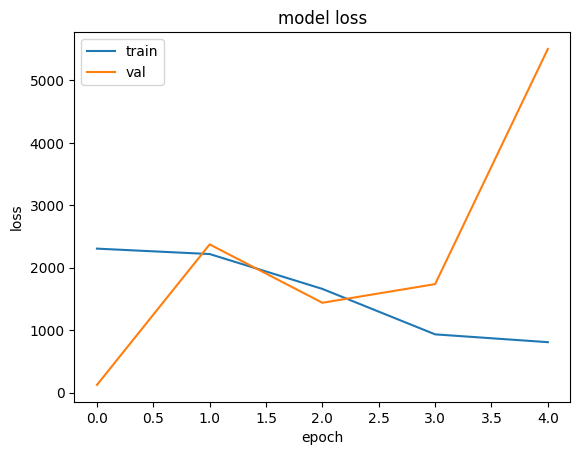

In [9]:
if __name__ == "__main__":
    print('vowlr')
    tf.keras.backend.clear_session()

    model = build_model(True)
    model.load_weights('macbeth.hdf5')
    history = train_model(model)
    loss_plot(history)




In [17]:
if __name__ == "__main__":
  print('vowlr')
  tf.keras.backend.clear_session()

  model = build_model(True)
  model.load_weights('macbeth.hdf5')

  x = reformat_mask_for_pred('./mask.jpg')
  y = model.predict(x)
  print(y)

vowlr


ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2] name: 